In [1]:
import pandas as pd
import numpy as np
import os
import wfdb
import ast

import tensorflow as tf
from tensorflow import keras
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Loading Data

In [2]:
'''function to load the data from the saved file path for different experiments. 
    Saved Data for future use and for conducting experiments as extracting data is resource intensive'''
def load_data(filepath, type, x_key='x', y_key='y'):
    # Load X_test and Y_test
    data = np.load(filepath)
    x = data[x_key]
    y = data[y_key]

    print (f"Shape of X-{type} and Y_{type} : {x.shape},  {y.shape}")
    return x, y

In [3]:
'''function to create dataset from the numpy array'''
def create_dataset(x, y, batch_size=256):
    dataset_X = tf.data.Dataset.from_tensor_slices(x)
    dataset_Y = tf.data.Dataset.from_tensor_slices(y)
    dataset =  tf.data.Dataset.zip((dataset_X, dataset_Y))

    ds = dataset.batch(batch_size, drop_remainder=True)

    for batch in ds.take(1):
        print([f"Shape of Batched Dataset {arr.numpy().shape}" for arr in batch])
    
    return ds

# Utils functions for Building and Evaluating Model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, MultiHeadAttention, Dense, Flatten, Input,GlobalAveragePooling1D, BatchNormalization,MaxPooling1D,Attention,LayerNormalization, Dropout,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, roc_auc_score

def evaluate_model(model, X_test, Y_test):
    # Predict labels for the test set
   # Get the predicted probabilities
    Y_pred_prob = model.predict(X_test)

    # Convert the predicted probabilities to class labels
    Y_pred = np.argmax(Y_pred_prob, axis=1)

    # Calculate evaluation metrics
    confusion = confusion_matrix(Y_test, Y_pred)
    report = classification_report(Y_test, Y_pred)
    accuracy = accuracy_score(Y_test, Y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(Y_test, Y_pred, average='weighted')
    #auc = roc_auc_score(Y_test, Y_pred)
    #num_parameters = model.count_params()  # Replace with the appropriate method to count model parameters

    # Create a dictionary of evaluation metrics
    evaluation = {
        'confusion_matrix': confusion,
        'classification_report': report,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        #'auc': auc,
        #'num_parameters': num_parameters
    }

    return evaluation

In [6]:
import seaborn as sns

def plot_confusion_matrix(confusion):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_classification_report(report):
    # Extract precision, recall, and F1-score from the report
    lines = report.split('\n')[2:-5]
    classes = []
    precision = []
    recall = []
    f1_score = []
    for line in lines:
        row = line.split()
        classes.append(row[0])
        precision.append(float(row[1]))
        recall.append(float(row[2]))
        f1_score.append(float(row[3]))

    # Plot precision, recall, and F1-score
    plt.figure(figsize=(10, 4))
    plt.bar(classes, precision, label='Precision')
    plt.bar(classes, recall, label='Recall')
    plt.bar(classes, f1_score, label='F1-Score')
    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.title('Classification Report')
    plt.legend()
    plt.show()
    
def plot_loss(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc_curves(Y_test, Y_scores):
    # Compute the number of classes
    num_classes = len(np.unique(Y_test))

    # Compute the fpr, tpr, and roc_auc for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test == i, Y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    plt.figure(figsize=(8, 6))

    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    classes = [f'Class {i}' for i in range(num_classes)]

    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of {classes[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

In [7]:
def display_output(model, history):

    Y_pred = model.predict(X_test)
    # Evaluate the model
    evaluation = evaluate_model(model, X_test, Y_test)
    
    #plot the history loss
    plot_loss(history)
    
    # Access individual evaluation metrics
    confusion = evaluation['confusion_matrix']
    report = evaluation['classification_report']
    print(f"Accuracy of the Model is  {evaluation['accuracy']}")
    print (f"Precision of the Model is {evaluation['precision']}")
    print (f"Recall of the Model is {evaluation['recall']}")
    print(f"F1 Score of the Model is {evaluation['f1_score']}")
    #auc = evaluation['auc']
    #num_parameters = evaluation['num_parameters']

    #plot the confusion matrix and classification report
    plot_confusion_matrix(confusion)
    plot_classification_report(report)

    plot_roc_curves(Y_test, Y_pred)

In [8]:
def get_optimizer(optimizer, learning_rate):
    if(optimizer=="adam"):
        return tf.keras.optimizers.Adam(learning_rate)
    elif (optimizer=="sgd"):
        return tf.keras.optimizers.SGD(learning_rate)
    elif (optimizer=="rmsprop"):
        return tf.keras.optimizers.RMSprop(learning_rate)
    elif (optimizer=="nadam"):
        return tf.keras.optimizers.Nadam(learning_rate)
    elif (optimizer=="adagrad"):
        return tf.keras.optimizers.Adagrad(learning_rate)
    else:
        return tf.keras.optimizers.Adam(learning_rate)

def get_callbacks(name):
    model_output = f'{name}.h5'
    
    return  [keras.callbacks.ModelCheckpoint(model_output, save_best_only=True, monitor="val_loss"),
                keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001),
                keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)]
    
def compile_and_fit(model, name,optimizer, epochs=30, batch_size=256, learning_rate=0.01,shuffle=False):
    optimizer = get_optimizer(optimizer, learning_rate)

    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])
    model.summary()
    history = model.fit(train_ds,
                      epochs=epochs,
                      validation_data=val_ds,
                      callbacks=get_callbacks(name),
                      verbose=1, batch_size=batch_size,shuffle=shuffle)
    return history

# Experiment 1 : (Raw Signal) --> CNN Model 

In [9]:
X_train, Y_train = load_data('/kaggle/input/raw-ecg/Raw_train.npz', 'train')
X_val, Y_val = load_data('/kaggle/input/raw-ecg/Raw_val.npz','val')
X_test, Y_test = load_data('/kaggle/input/raw-ecg/Raw_test.npz','test')

Shape of X-train and Y_train : (11297, 12, 1000),  (11297,)
Shape of X-val and Y_val : (3268, 12, 1000),  (3268,)
Shape of X-test and Y_test : (1670, 12, 1000),  (1670,)


In [10]:
train_ds = create_dataset(X_train, Y_train)
val_ds = create_dataset(X_val, Y_val)

['Shape of Batched Dataset (256, 12, 1000)', 'Shape of Batched Dataset (256,)']
['Shape of Batched Dataset (256, 12, 1000)', 'Shape of Batched Dataset (256,)']


In [11]:
#HYPER_PARAMETERS
BATCH_SIZE = 256
num_classes = 5
LEARNING_RATE = 0.01
input_shape = X_train.shape[1:]
activation_fn = 'relu'

In [12]:
# Create the Conv1D model
def create_conv1d_model(input_shape):
    model = Sequential()
    model.add(Conv1D(256, 3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Conv1D(256, 3, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(3, strides=1, padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv1D(256, 3, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(3, strides=1, padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [13]:
conv1d_model = create_conv1d_model(input_shape)

In [14]:
history = compile_and_fit(conv1d_model,"expt1_conv1d_model",optimizer='adam',epochs=20,batch_size=256,learning_rate=0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 256)           768256    
                                                                 
 batch_normalization (BatchN  (None, 10, 256)          1024      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 256)            196864    
                                                                 
 batch_normalization_1 (Batc  (None, 8, 256)           1024      
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 256)           0         
 )                                                               
                                                        

53/53 [==============================] - 1s 10ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

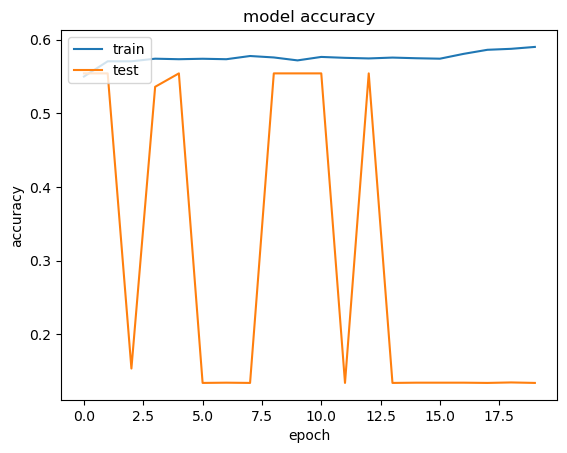

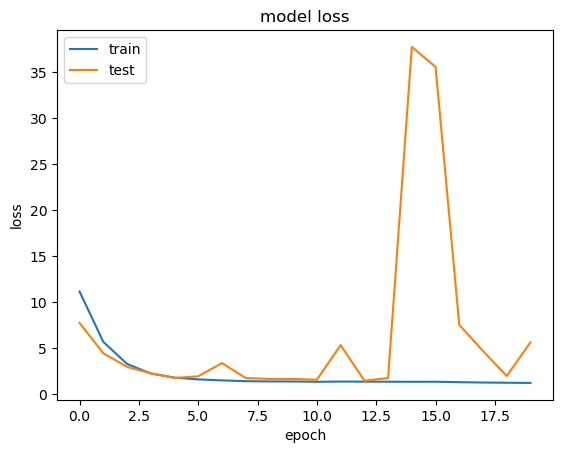

Accuracy of the Model is  0.13832335329341316
Precision of the Model is 0.019133350066334397
Recall of the Model is 0.13832335329341316
F1 Score of the Model is 0.03361672236799415


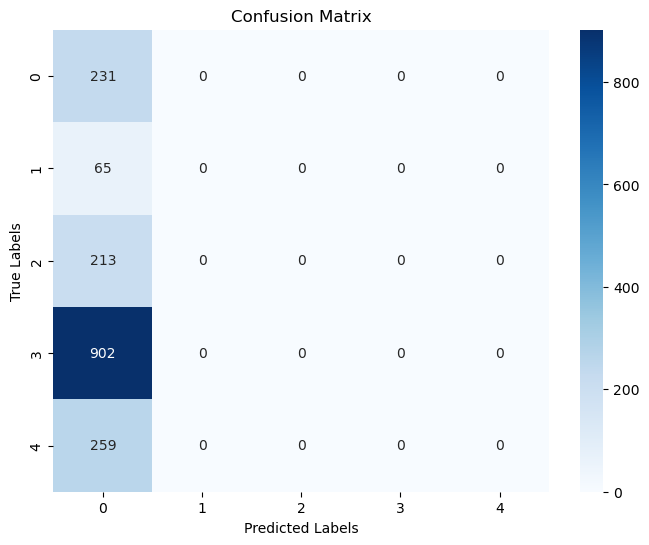

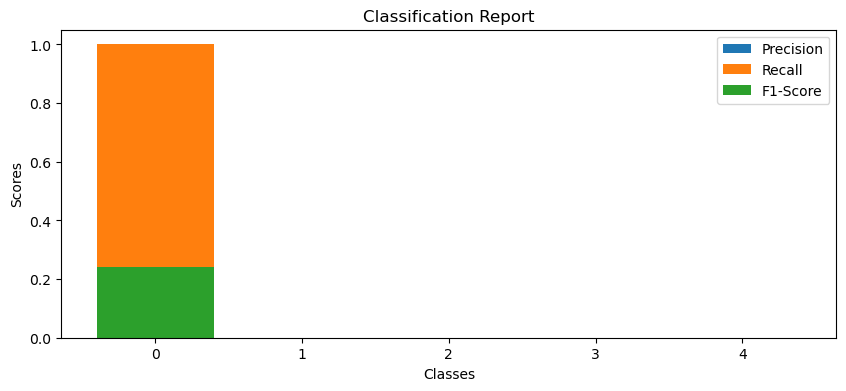

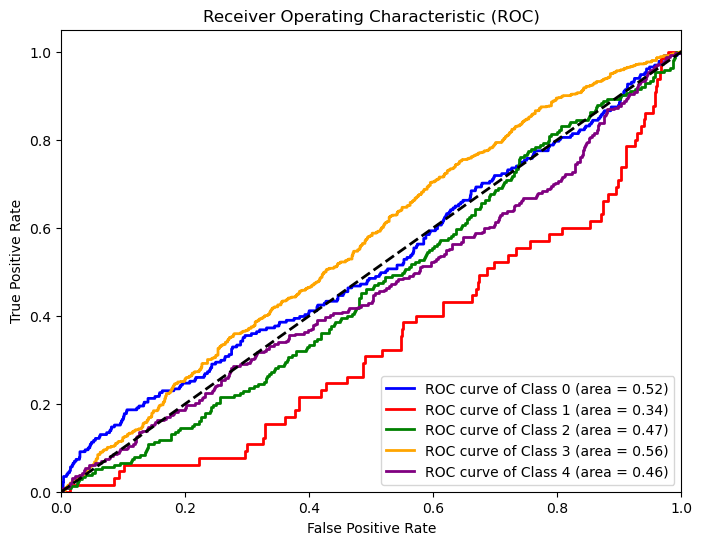

In [15]:
display_output(conv1d_model, history)

# Experiment 2: LSTM Model 

In [16]:

# Create the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(LSTM(64,return_sequences=True,))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(LSTM(64,return_sequences=True,))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(3, strides=1, padding='same'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='sigmoid'))
    return model

In [17]:
lstm_model = create_lstm_model(input_shape)

In [18]:
history = compile_and_fit(lstm_model,"expt2_lstm_model",optimizer='adam',epochs=25,batch_size=256,learning_rate=0.001)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            272640    
                                                                 
 batch_normalization_5 (Batc  (None, 12, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 12, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 64)            33024     
                                                                 
 batch_normalization_6 (Batc  (None, 12, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 12, 64)           

53/53 [==============================] - 1s 11ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

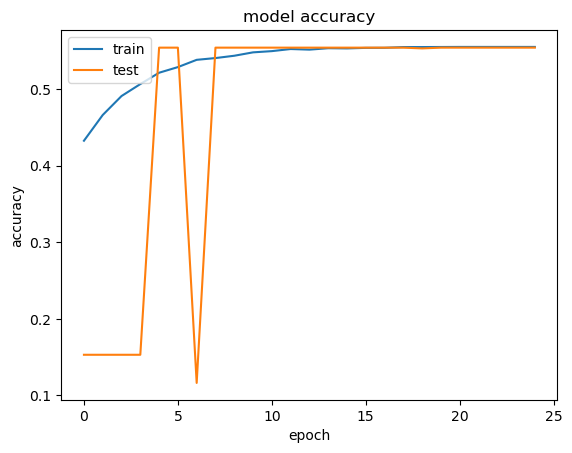

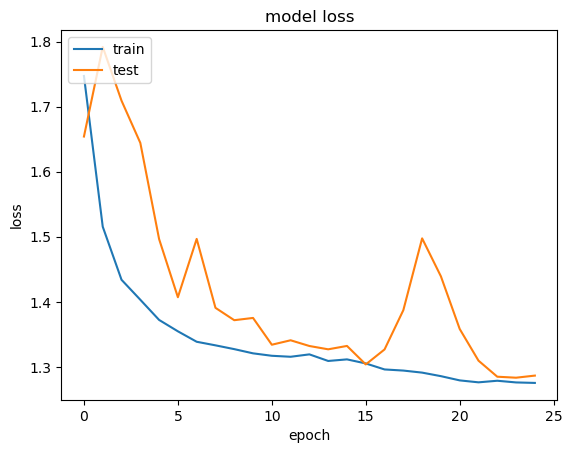

Accuracy of the Model is  0.5401197604790419
Precision of the Model is 0.2917293556599376
Recall of the Model is 0.5401197604790419
F1 Score of the Model is 0.3788398320000745


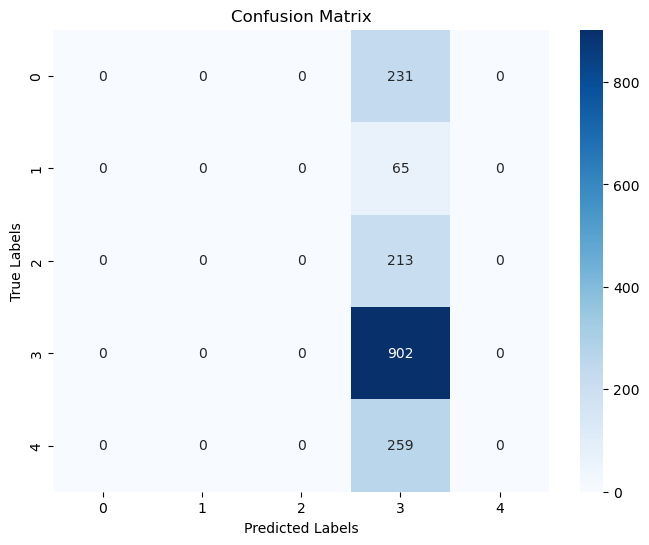

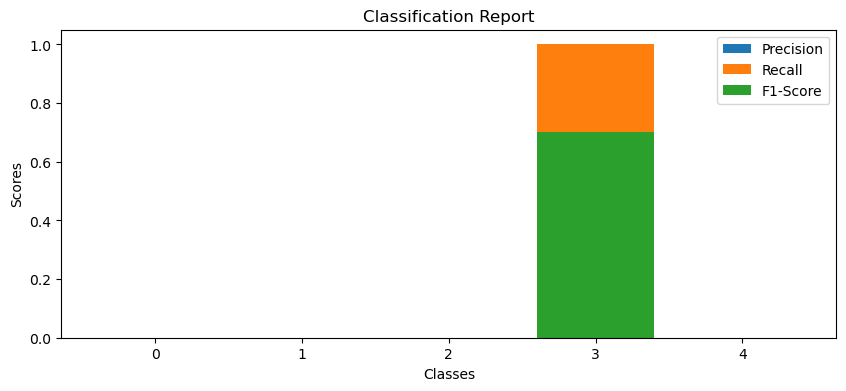

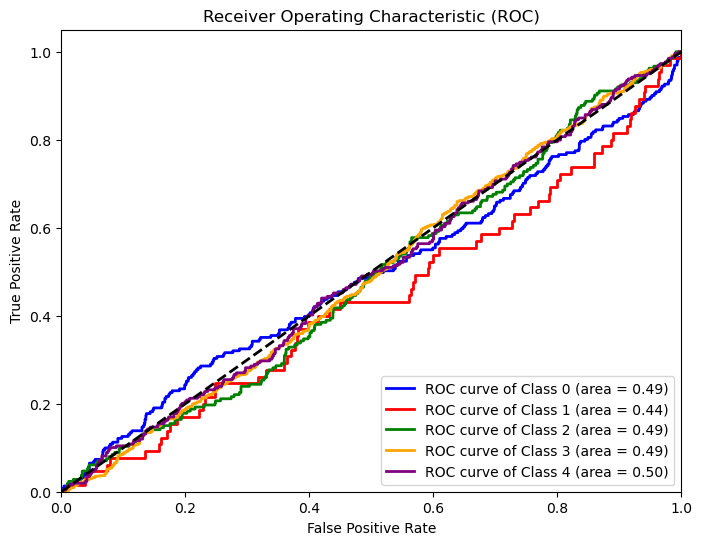

In [19]:
display_output(lstm_model, history)

# Experiment 3: 1D CNN MHA (Multi Head Attention) model

In [20]:
def create_conv1d_mha_model(input_shape, regularizer=0.01):
    inputs = Input(shape=input_shape)
    
    # Convolutional layers
    conv1 = Conv1D(32, 1, activation='relu')(inputs)
    batch_norm1 =  BatchNormalization()(conv1)
    conv2 = Conv1D(64, 1, activation='relu')(batch_norm1)
    batch_norm2 =  BatchNormalization()(conv2)
    max_pooling1 =  MaxPooling1D(3, strides=1, padding='same')(batch_norm2)
    dropout1 = Dropout(0.2)(max_pooling1)
    conv3 = Conv1D(128, 1, activation='relu')(dropout1)
    batch_norm3 =  BatchNormalization()(conv3)
    dropout2 = Dropout(0.3)(batch_norm3)
    conv4 = Conv1D(128, 1, activation='relu')(dropout2)
    batch_norm4 =  BatchNormalization()(conv4)
    max_pooling2 =  MaxPooling1D(3, strides=1, padding='same')(batch_norm4)
    conv5 = Conv1D(512, 1, activation='relu')(max_pooling2)
    batch_norm5 =  BatchNormalization()(conv5)
    conv6 = Conv1D(512, 1, activation='relu')(batch_norm5)
    # Multi-head attention
    attention = MultiHeadAttention(num_heads=5, key_dim=3)(conv6, conv6)
    attention = LayerNormalization(epsilon=1e-6)(attention)
    
    # Concatenate attention output and conv3
    concat = Concatenate()([conv6, attention])
    
    # Global average pooling
    pool = tf.keras.layers.GlobalAveragePooling1D()(concat)
    
    dropout3 = Dropout(0.3)(pool)
    
     # Dense layers
    dense1 = Dense(256, activation='relu')(dropout3)
    dropout4 = Dropout(0.5)(dense1)
    dense2 = Dense(128, activation='relu')(dropout4)
    # Dense layer
    dense = Dense(num_classes, activation='softmax',
                  kernel_regularizer=regularizers.l2(regularizer))(dense2) 
    
    # Create model
    model = Model(inputs=inputs, outputs=dense)
    
    return model


In [21]:
conv1d_mha_model= create_conv1d_mha_model(input_shape)

In [22]:
history = compile_and_fit(conv1d_mha_model,"expt3_cnn_mha_model",optimizer='adam',epochs=25,batch_size=256,learning_rate=0.001)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 1000)]   0           []                               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 12, 32)       32032       ['input_1[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 12, 32)      128         ['conv1d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv1d_6 (Conv1D)              (None, 12, 64)       2112        ['batch_normalization_8[0][0]

53/53 [==============================] - 1s 10ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

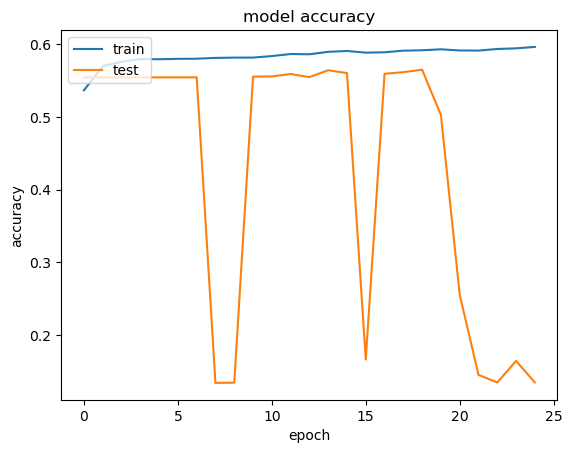

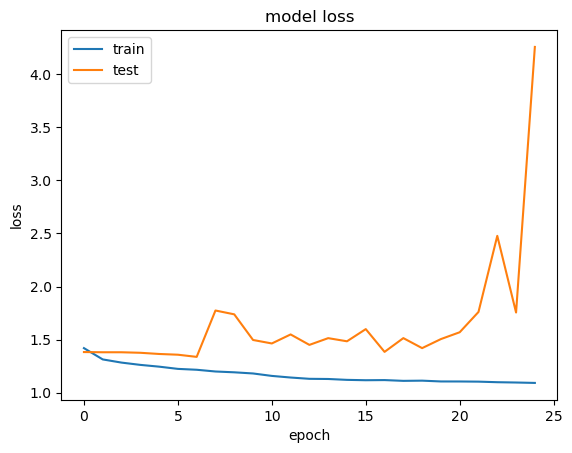

Accuracy of the Model is  0.13832335329341316
Precision of the Model is 0.01917928848185981
Recall of the Model is 0.13832335329341316
F1 Score of the Model is 0.03368760633714122


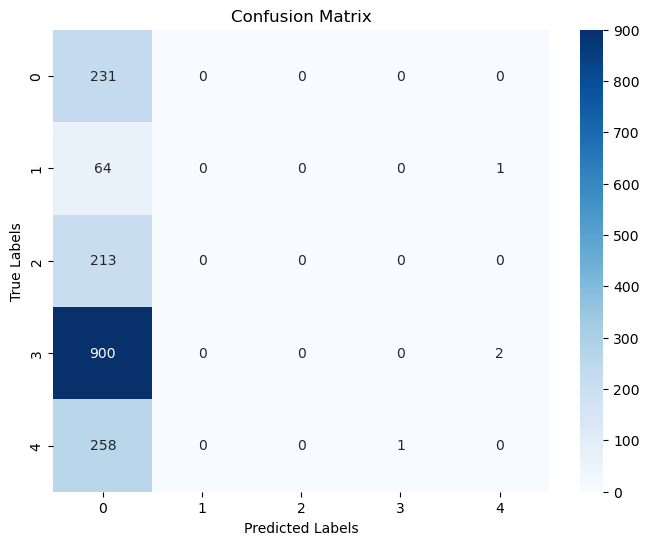

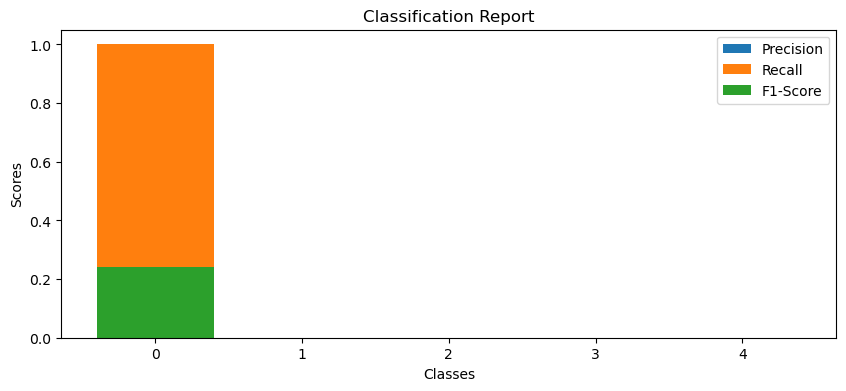

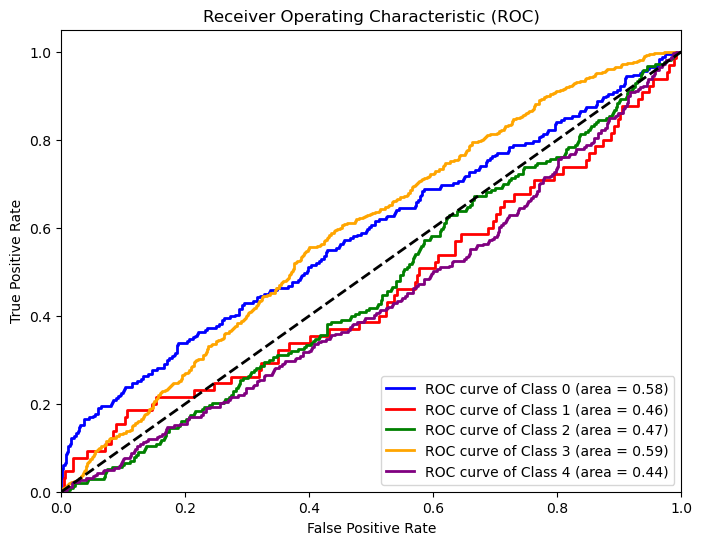

In [23]:
display_output(conv1d_mha_model, history)

# Experiment 4: VGG Model

In [24]:
# Define the VGGNet-based model
def create_vggnet_model(input_shape, num_classes):
    model = Sequential()

    # Block 1
    model.add(Conv1D(64, kernel_size=1, activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv1D(64, kernel_size=1, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=1, strides=1))

    # Block 2
    model.add(Conv1D(128, kernel_size=2, activation='relu', padding='same'))
    model.add(Conv1D(128, kernel_size=2, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=1))

    # Block 3
    model.add(Conv1D(256, kernel_size=2, activation='relu', padding='same'))
    model.add(Conv1D(256, kernel_size=2, activation='relu', padding='same'))
    model.add(Conv1D(256, kernel_size=2, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))

    # Block 4
    model.add(Conv1D(512, kernel_size=2, activation='relu', padding='same'))
    model.add(Conv1D(512, kernel_size=2, activation='relu', padding='same'))
    model.add(Conv1D(512, kernel_size=2, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))

    # Block 5
    model.add(Conv1D(512, kernel_size=2, activation='relu', padding='same'))
    model.add(Conv1D(512, kernel_size=2, activation='relu', padding='same'))
    model.add(Conv1D(512, kernel_size=2, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [25]:
vggnet_model = create_vggnet_model(input_shape, 5)

In [26]:
history = compile_and_fit(vggnet_model,"expt4_vggnet_model",optimizer='adam',epochs=15,batch_size=256,learning_rate=0.001)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 12, 64)            64064     
                                                                 
 conv1d_12 (Conv1D)          (None, 12, 64)            4160      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 12, 64)           0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 12, 128)           16512     
                                                                 
 conv1d_14 (Conv1D)          (None, 12, 128)           32896     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 11, 128)          0         
 1D)                                                  

53/53 [==============================] - 2s 36ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

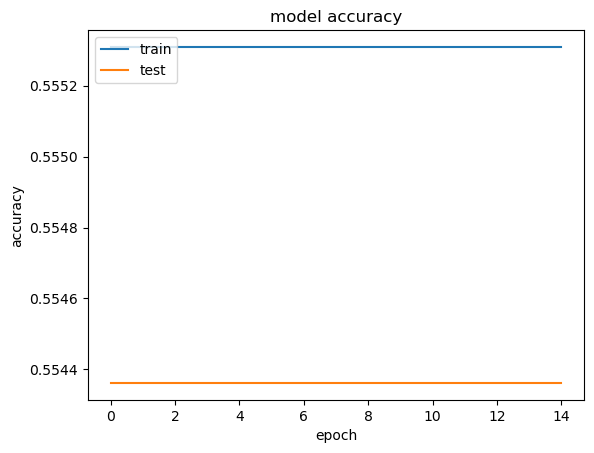

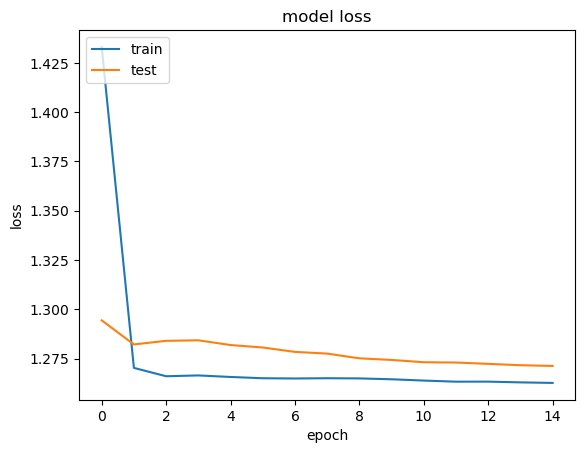

Accuracy of the Model is  0.5401197604790419
Precision of the Model is 0.2917293556599376
Recall of the Model is 0.5401197604790419
F1 Score of the Model is 0.3788398320000745


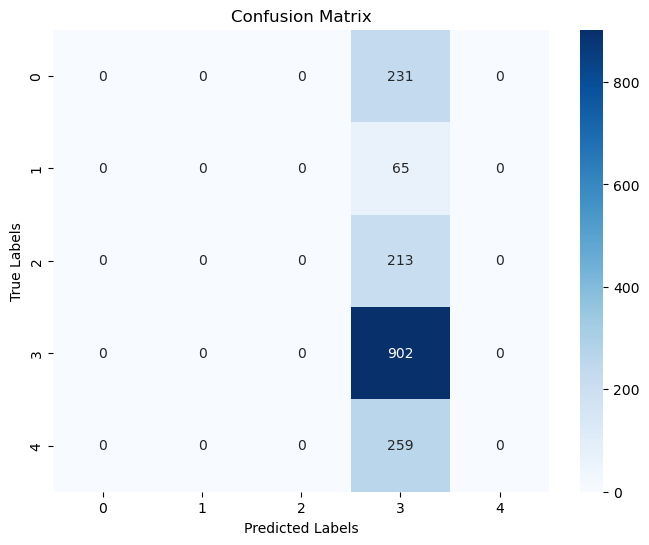

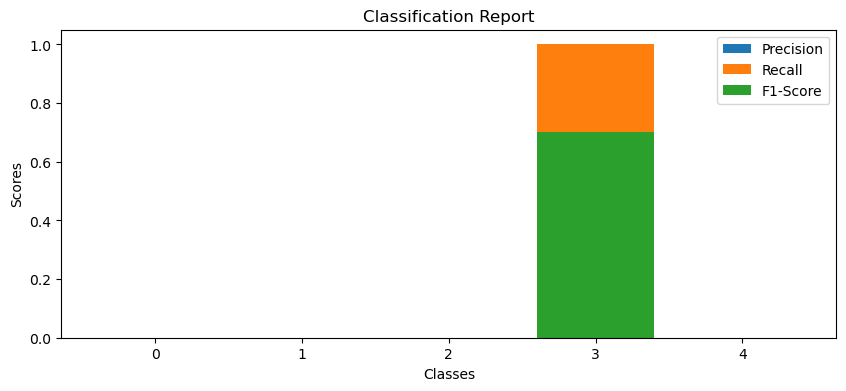

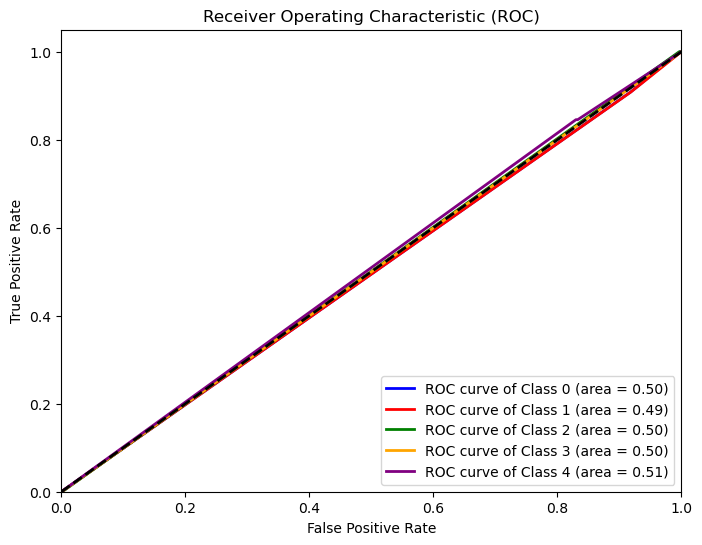

In [27]:
display_output(vggnet_model, history)

# Experiment 5 - # 1-D CNN, Multi-head attention (Feature Selection) 188 features

In [28]:
X_train, Y_train = load_data('/kaggle/input/ecg-features-train/X_Features_train.npz', 'train', "X", "Y")
X_val, Y_val = load_data('/kaggle/input/ecg-features-fe/X_Features_val.npz','val', "X", "Y")
X_test, Y_test = load_data('/kaggle/input/ecg-features-fe/X_Features_test.npz','test', "X","Y")

Shape of X-train and Y_train : (11297, 12, 188),  (11297,)
Shape of X-val and Y_val : (3268, 12, 188),  (3268,)
Shape of X-test and Y_test : (1670, 12, 188),  (1670,)


In [29]:

train_ds = create_dataset(X_train, Y_train)
val_ds = create_dataset(X_val, Y_val)

['Shape of Batched Dataset (256, 12, 188)', 'Shape of Batched Dataset (256,)']
['Shape of Batched Dataset (256, 12, 188)', 'Shape of Batched Dataset (256,)']


In [30]:
input_shape = X_train.shape[1:]
conv1d_mha_model= create_conv1d_mha_model(input_shape)

In [31]:
history = compile_and_fit(conv1d_mha_model,"expt5_cnn_mha_model",optimizer='adam',epochs=100,batch_size=256,learning_rate=0.001)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 12, 188)]    0           []                               
                                                                                                  
 conv1d_24 (Conv1D)             (None, 12, 32)       6048        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_13 (BatchN  (None, 12, 32)      128         ['conv1d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_25 (Conv1D)             (None, 12, 64)       2112        ['batch_normalization_13[0]

53/53 [==============================] - 1s 10ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

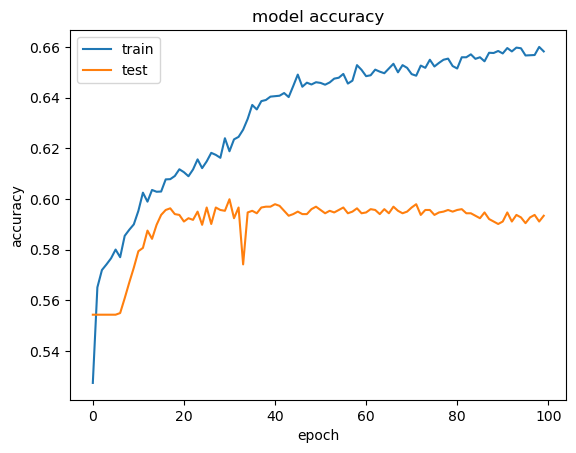

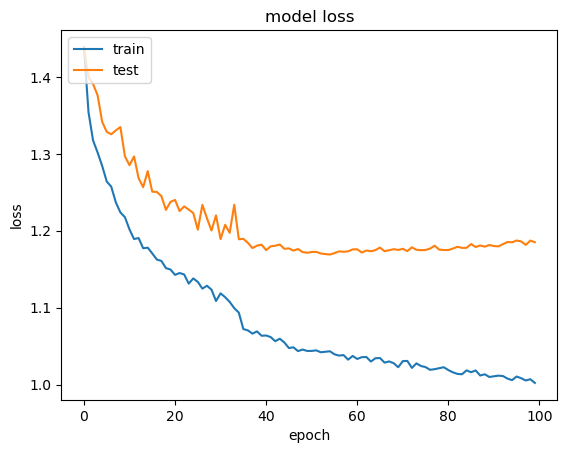

Accuracy of the Model is  0.5790419161676646
Precision of the Model is 0.5351118887368776
Recall of the Model is 0.5790419161676646
F1 Score of the Model is 0.4875825747465665


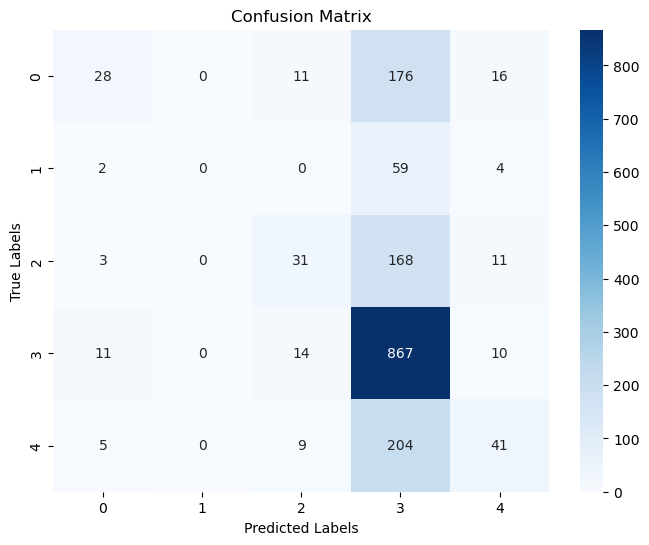

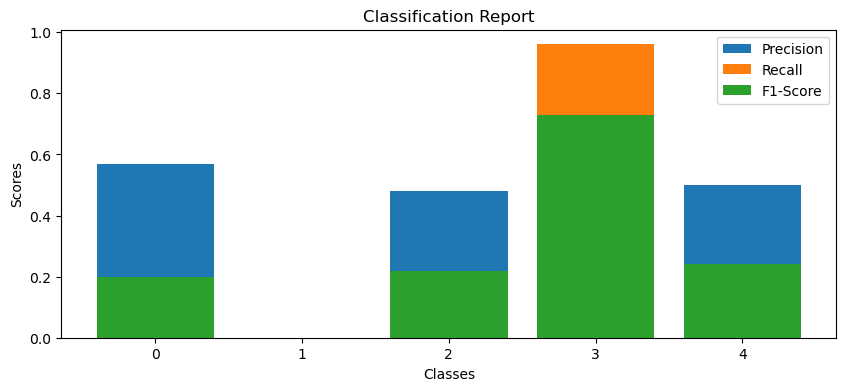

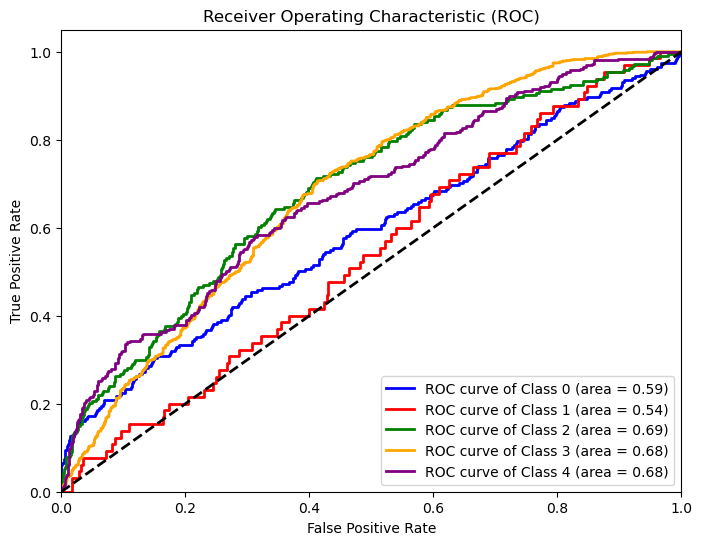

In [32]:
display_output(conv1d_mha_model,history)

# Experiment 5.1 - # 1-D CNN, Multi-head attention (Feature Selection + Additional Features)

In [33]:
X_train, Y_train = load_data('/kaggle/input/fe-all/X_AllFeatures_train.npz', 'train')
X_val, Y_val = load_data('/kaggle/input/fe-all/X_AllFeatures_val.npz','val')
X_test, Y_test = load_data('/kaggle/input/fe-all/X_AllFeatures_test.npz','test')

Shape of X-train and Y_train : (11297, 12, 365),  (11297,)
Shape of X-val and Y_val : (3268, 12, 365),  (3268,)
Shape of X-test and Y_test : (1670, 12, 365),  (1670,)


In [34]:
train_ds = create_dataset(X_train, Y_train)
val_ds = create_dataset(X_val, Y_val)

['Shape of Batched Dataset (256, 12, 365)', 'Shape of Batched Dataset (256,)']
['Shape of Batched Dataset (256, 12, 365)', 'Shape of Batched Dataset (256,)']


In [35]:
input_shape = X_train.shape[1:]
conv1d_mha_model= create_conv1d_mha_model(input_shape, 0.001)

In [36]:
history = compile_and_fit(conv1d_mha_model,"expt5.1_cnn_mha_model",optimizer='adam',epochs=100,batch_size=128,learning_rate=0.001)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 12, 365)]    0           []                               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 12, 32)       11712       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 12, 32)      128         ['conv1d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_31 (Conv1D)             (None, 12, 64)       2112        ['batch_normalization_18[0]

53/53 [==============================] - 1s 10ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

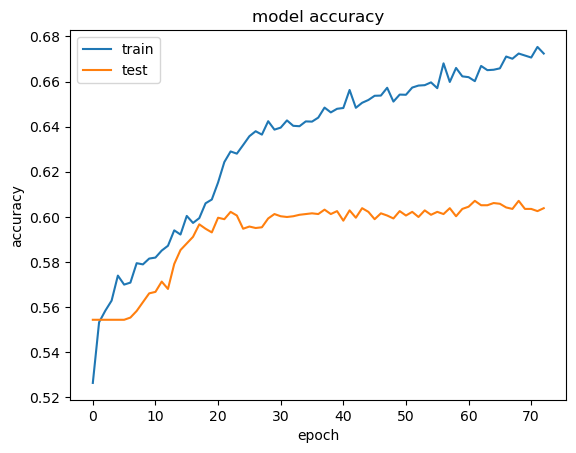

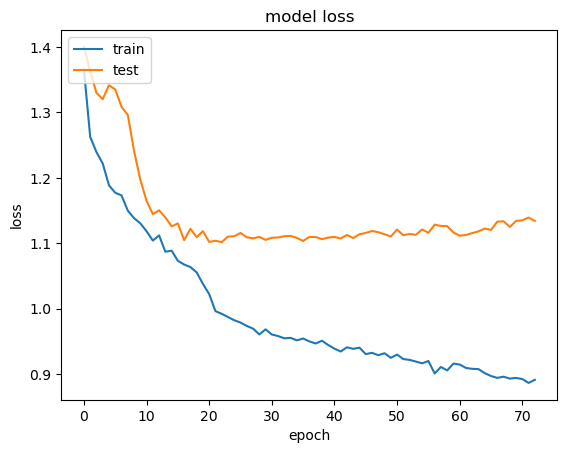

Accuracy of the Model is  0.581437125748503
Precision of the Model is 0.5434977478044578
Recall of the Model is 0.581437125748503
F1 Score of the Model is 0.48578755773271803


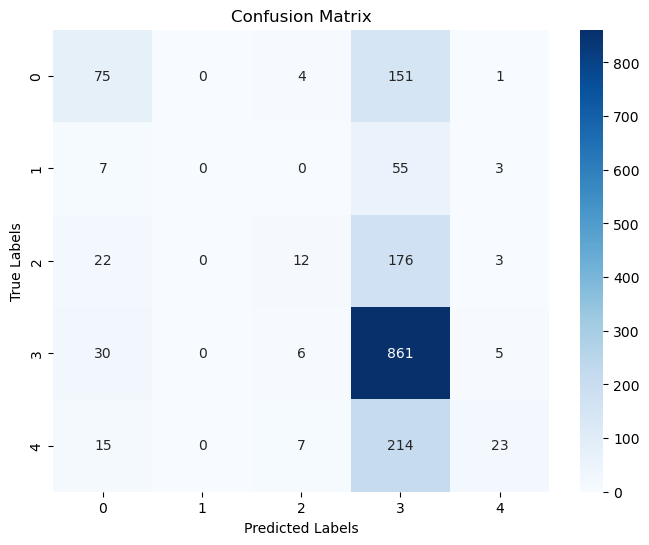

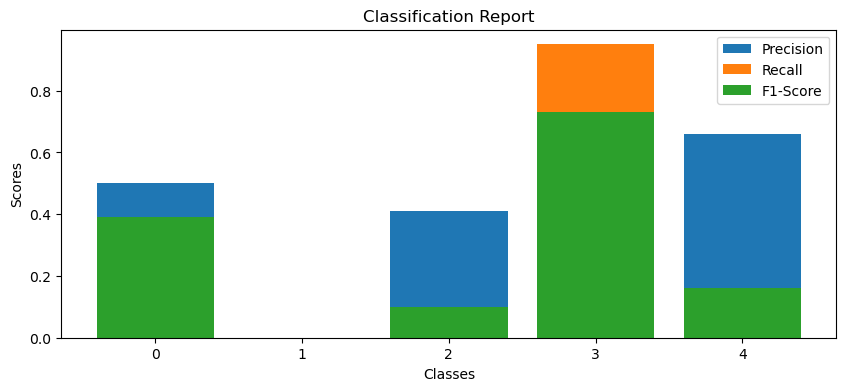

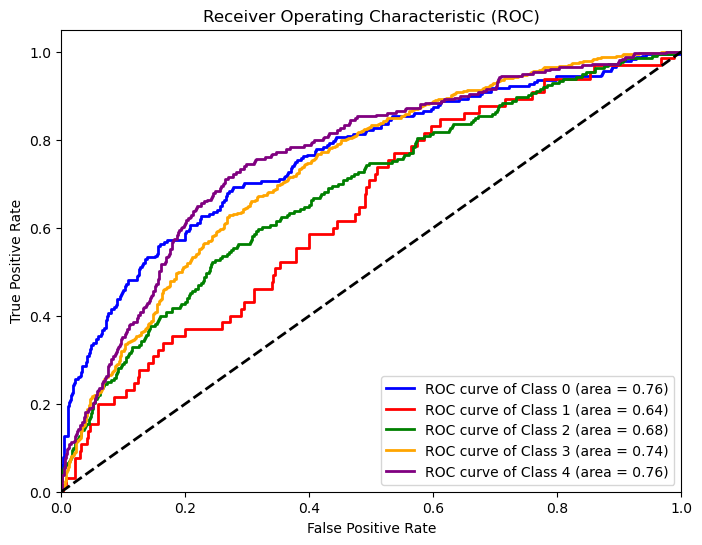

In [37]:
display_output(conv1d_mha_model, history)

# Experiment 6 - # 1-D CNN, Multi-head attention + Ensemble Classifier (Raw Signal + Feature Selection)